
# Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Инструкция по выполнению проекта**

* Загрузите данные и выполните их ресемплирование по одному часу.
* Проанализируйте данные.
* Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
* Проверьте данные на тестовой выборке и сделайте выводы.

**Описание данных**

Данные лежат в файле taxi.csv. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).



In [175]:
!pip install catboost
!pip install xgboost

In [176]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from statsmodels.tsa.seasonal import seasonal_decompose

# ML
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor, Pool
import xgboost as xgb


In [177]:
taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [178]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [179]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Исходный датасет содержит 26496 наблюдений, временной интревал наблюдений составляет 10 минут.
Пропущенных значений нет.
При первичном анализе установлено, что временной промежуток данных длится с 1 марта 2018 года по 31 августа 2018 года. Проверим монотонность даты (индекса).

In [180]:
if taxi.index.is_monotonic == True :
    print('Даты расположены в хронологическом порядке')
else:
    print('Требуется предобработка')

Даты расположены в хронологическом порядке


In [181]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

На данном шаге были загружены данные и требуемые библиотеки.
Первичный анализ временных рядов не выявил аномалий и пропущенных значений. Данные о числе заказов также не содержат пропусков.

# 2 Анализ данных


In [182]:
taxi.sort_values(by='num_orders')

,num_orders
datetime,
2018-04-06 06:00:00,0
2018-04-05 06:00:00,1
2018-03-09 05:00:00,1
2018-04-03 06:00:00,1
2018-04-24 06:00:00,2
...,...
2018-08-27 04:00:00,295
2018-08-30 17:00:00,342
2018-08-27 02:00:00,408



462 заказа в 2 часа ночи 20 августа - люди прилетают с отпусков. И полное отсутсвие в 6 утра 6 апреля - никому никуда не нужно. В целом - отрицательных и сверх-огромных значений не замечено.
Посмотрим на диаграмму распределения.

Медианное значение заказов =  78.0


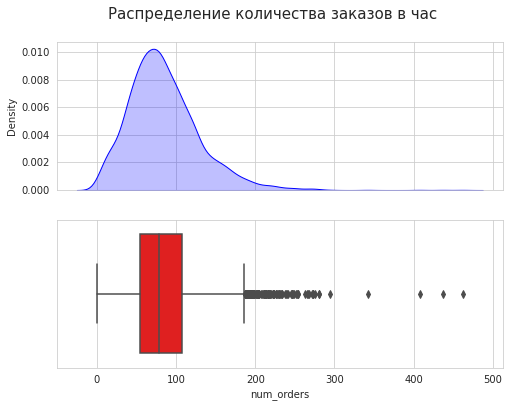

In [183]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2,1,sharex=True, figsize=(8,6))

sns.kdeplot(taxi['num_orders'], color='blue', shade=True, label='Количество заказов', ax=axes[0])
sns.boxplot(taxi['num_orders'], orient='h', color='red')

plt.suptitle('Распределениe количества заказов в час', size=15, y=(0.96));

print('Медианное значение заказов = ', taxi['num_orders'].median())

Чаще всего в час поступает в районе 78 заказов.


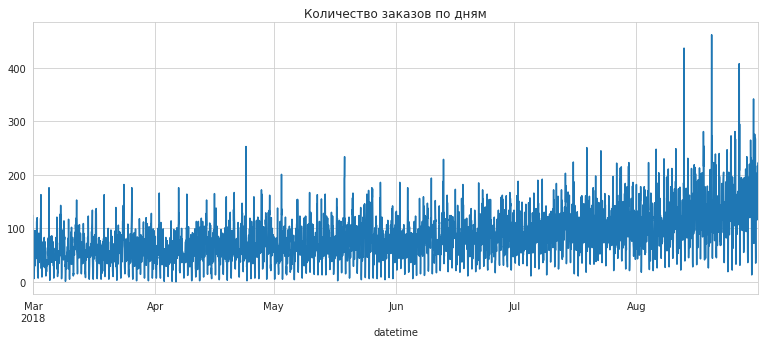

In [184]:
plt.figure(figsize=(13,5))
plt.title('Количество заказов по дням')
taxi['num_orders'].plot()

**Анализ временных рядов**

Проверим, к какому типу принадлежит наш временной ряд.

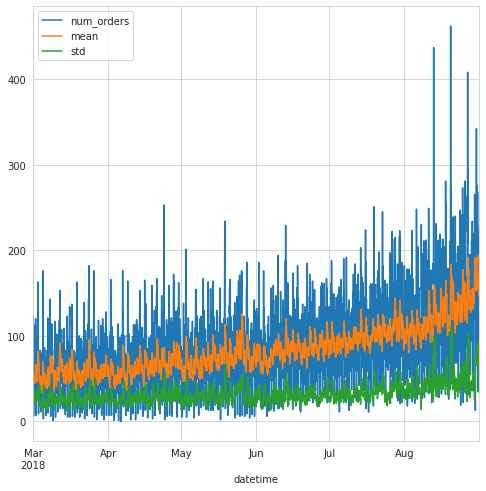

In [185]:
taxi['mean'] = taxi['num_orders'].rolling(15).mean()
taxi['std'] = taxi['num_orders'].rolling(15).std()

taxi.plot(figsize=(8,8));


Скользящее среднее отклонение со временем изменяеся не слишком сильно. При этом среднее значение - достаточно высоко поднимется в августе. Из этого следует, что перед нами - нестационарный временной ряд.

Изучим тренд и сезонность.

In [186]:
taxi = taxi.drop(['mean','std'], axis=1)

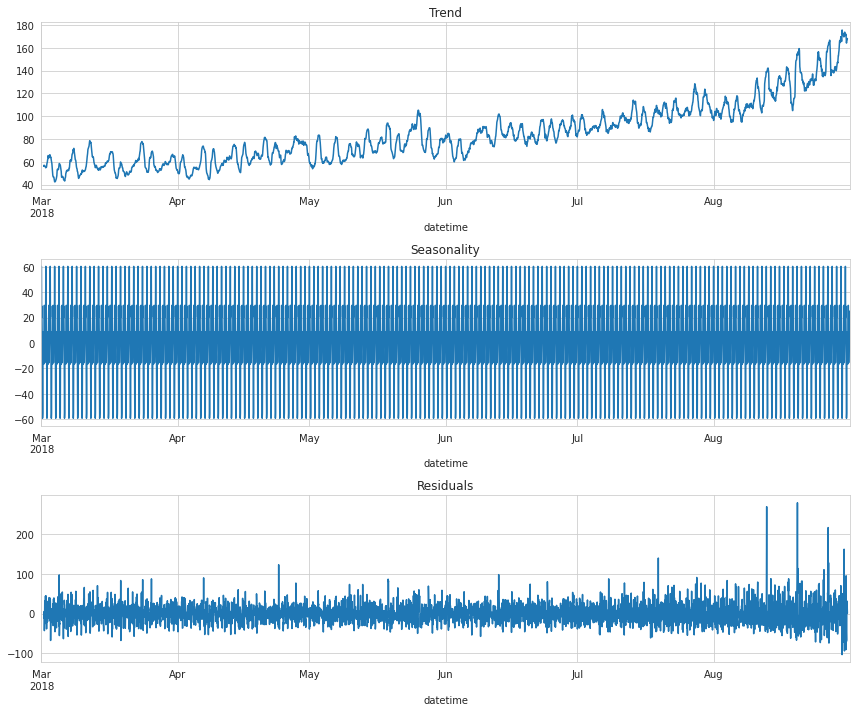

In [187]:
# Произвожу декомпозицию временного ряда, что увидеть тренд, сезонность и белый шум
decomposed = seasonal_decompose(taxi['num_orders'])

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На данном графике заметен глобальный тренд увеличения числа заказов такси на протяжении всего изучаемого периода.
Колебяния сезонности на данном графике изучить невозможно, попробуем увеличить масштаб.
Посмотрим на два разных месяца - апрель и август и первые трое суток.

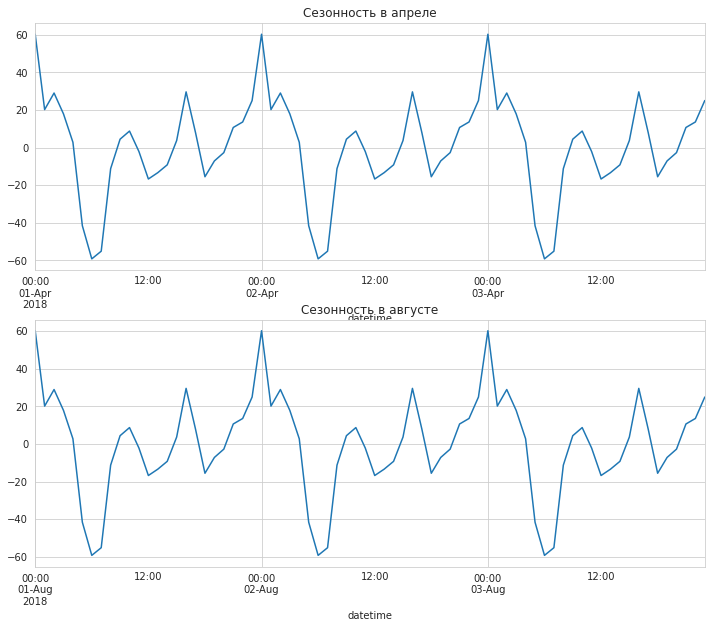

In [188]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
decomposed.seasonal['2018-04-01':'2018-04-03'].plot(ax=plt.gca())
plt.title('Сезонность в апреле')
plt.subplot(212)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.title('Сезонность в августе');


Больше всего заказов такси приходится на 00 часов. Выскажу предположение о том, что в этот момент прилетает много самолетов и отсустствует дополнительный наземный транспорт, которым можно добраться из аэропорта.
Минимальное количество заказов в районе 6-7 часов утра.
Так же заметен второй по величине пик заказов в районе 16-17 дня.

Выдвину гипотезу о том, что на основании текущих данных, именно в эти моменты компании "Четенькое такси" необходимо увеличивать количество водителей на маршрутах.

Текущий анализ данных завершен, переходим к выводам.

# Вывод

На данном этапе был произведен анализ исходных данных. За время исследования обнаружены следующие особенности:

1. Чаще всего за час в службу такси поступают 78 заказов,
2. На протяжении всего года заметен тренд к увеличению количество заказов,
4. Обнаружена "сезонность" загруженности: пиковые часы приходятся на 00 и 16-17 часов вечера,
4. Минимальная загрузка наблюдается в течение часа, с 6 до 7 утра, так же две небольшие просадки количества заказов заметны в 12 и 18 часов.

На основании первичных полученных данных можно предположить о необходимости усиления рабочих смен таксистов именно указанные выше часы.

Переходим к более точному прогнозированию и обучению моделей.

In [189]:
def new_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [190]:
new_features(taxi, 10, 10)

In [191]:
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



У нас остаются пропущенные значения, но их не так много и они будут удалены после разбития на выборки.



**Создание подвыборок**

Разобьем датасет на обучающую, валидационную и тестовую выборку.

In [192]:
sub, test = train_test_split(taxi, test_size=.1, shuffle=False)
train, valid = train_test_split(sub, test_size=.1, shuffle=False)

In [193]:
train.dropna(inplace=True)

In [194]:
train.shape[0], valid.shape[0], test.shape[0]

(3566, 398, 442)

In [195]:
X_train = train.drop(['num_orders'], axis=1)
X_valid = valid.drop(['num_orders'], axis=1)
X_test = test.drop(['num_orders'], axis=1)

y_train = train['num_orders']
y_valid = valid['num_orders']
y_test = test['num_orders']

**Подбор и тестирование моделей**

**Логистическая регрессия**

Попробуем применить простенькую логистическую регрессию.

In [196]:
%%time
lr = LinearRegression().fit(X_train, y_train)

CPU times: user 3.27 ms, sys: 6.19 ms, total: 9.45 ms
Wall time: 10.2 ms


In [197]:
def prediction(model, feat, targ):
    
    pred = model.predict(feat)
    rmse = mean_squared_error(pred, targ)**0.5
    
    return(rmse)

In [198]:
%%time
prediction(lr, X_valid, y_valid)

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.88 ms


40.570413007041196

Сразу создадим табличку, в которую будем вносить полученые данные

In [199]:
res = {
    'model_name':pd.Series(['LogReg','KNN','LinSVM','GradBoost','CatBoost']),
    'training_time':pd.Series([11.1]),
    'prediction_valid_time':pd.Series([8.51]), 
    'rmse_valid':pd.Series([40.57]), 
    'prediction_test_time':pd.Series([]), 
    'rmse_test':pd.Series([])}

results = pd.DataFrame(res)
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,11.1,8.51,40.57,NaN,NaN
1,KNN,NaN,NaN,NaN,NaN,NaN
2,LinSVM,NaN,NaN,NaN,NaN,NaN
3,GradBoost,NaN,NaN,NaN,NaN,NaN
4,CatBoost,NaN,NaN,NaN,NaN,NaN


**Метод ближайших соседей**

Вспомним по класс моделей, которые мы не использовали достаточно давно. Для применения данной и следующей модели нам необходимо скалировать данные. К работе с соседями применим MinMax преобразование.

In [200]:
min_max = MinMaxScaler()

min_max.fit(X_train)

X_train_mm = min_max.transform(X_train)
X_valid_mm = min_max.transform(X_valid)
X_test_mm = min_max.transform(X_test)

Напишем функцию серча гиперпараметров.

In [201]:
def grid(model, params, feat, targ):
  search = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
  search.fit(feat, targ)
    
  print('Best score = ', search.best_score_)
  print(search.best_params_)

In [202]:
knn = KNeighborsRegressor()

knn_params = dict(n_neighbors=range(3,10),
                   metric=['minkowski', 'manhattan'],
                   leaf_size=[20,25,30,35],
                   algorithm=['auto','ball_tree','kd_tree'])

In [203]:
grid(knn, knn_params, X_train_mm, y_train)

Best score =  -603.305166739007
{'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9}


In [204]:
knn = KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan', n_neighbors=9)

In [205]:
%%time
knn.fit(X_train_mm, y_train)

CPU times: user 8.16 ms, sys: 0 ns, total: 8.16 ms
Wall time: 7.86 ms


KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [206]:
%%time
prediction(knn, X_valid_mm, y_valid)

CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 44.5 ms


35.61568713080818

In [207]:
results.loc[1, 'training_time'] = 8
results.loc[1, 'prediction_valid_time'] = 44.1
results.loc[1, 'rmse_valid'] = 35.61
results.head()

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,11.1,8.51,40.57,NaN,NaN
1,KNN,8.0,44.10,35.61,NaN,NaN
2,LinSVM,NaN,NaN,NaN,NaN,NaN
3,GradBoost,NaN,NaN,NaN,NaN,NaN
4,CatBoost,NaN,NaN,NaN,NaN,NaN


**Linear Support Vector Regressor**

Еще один класс линейных моделей. Как оказалось, достаточно мощно и быстро может обрабатывать большие массивы данных. Однако, у нас есть слишком сильно отклоняющие значения и прогноз на тестовой выборке может быть не слишком точным.

В данном случае скалируем данные с помощью StandardScaler

In [208]:
st_sc = StandardScaler()

st_sc.fit(X_train)

X_train_ss = st_sc.transform(X_train)
X_valid_ss = st_sc.transform(X_valid)
X_test_ss = st_sc.transform(X_test)

In [209]:
svm = LinearSVR(random_state=42)

svm_params = dict(max_iter=[100,500,1000,1200,1500],
                  C=[0.1,0.5,1],
                  tol=[1e-3, 1e-4, 1e-5])

In [210]:
grid(svm, svm_params, X_train_ss, y_train)

Best score =  -886.1159748027234
{'C': 1, 'max_iter': 100, 'tol': 1e-05}


In [211]:
svm = LinearSVR(random_state=42, C=1, max_iter=100, tol=0.0001)

In [212]:
%%time
svm.fit(X_train_ss, y_train)

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 7.8 ms


LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
          random_state=42, tol=0.0001, verbose=0)

In [213]:
%%time
prediction(svm, X_valid_ss, y_valid)

CPU times: user 968 µs, sys: 0 ns, total: 968 µs
Wall time: 1.71 ms


41.31250816813142

In [234]:
results.loc[2, 'training_time'] = 13.6
results.loc[2, 'prediction_valid_time'] =1.4
results.loc[2,'rmse_valid'] = 41.31
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,11.1,8.51,40.57,NaN,NaN
1,KNN,8.0,44.10,35.61,NaN,NaN
2,LinSVM,13.6,1.40,41.31,NaN,NaN
3,GradBoost,2230.0,7.99,32.88,NaN,NaN
4,CatBoost,227.0,6.20,38.68,NaN,NaN


**Gradient Boosting Regressor**

Данный класс модели не требует у нас скалирования данных. Переходим сразу к подбору гиперпараметров и обучению.

Поиск параметров проводим в 2 этапа - сначала подбираем лучшее количество деревьев, затем - остальные параметры.

In [215]:
gbr = GradientBoostingRegressor(random_state=42)

gbr_params_est = dict(n_estimators=range(100,1000,10))

gbr_params_other = dict(learning_rate=[0.1,1],
                        max_depth=[2,3,4,5],
                        min_samples_split=[2,3,4], 
                        tol=[1e-3, 1e-4, 1e-5])

In [216]:
#grid(gbr, gbr_params_est, X_train, y_train)

In [217]:
gbr = GradientBoostingRegressor(random_state=42, n_estimators=200)

In [218]:
#grid(gbr, gbr_params_other, X_train, y_train)

In [219]:
gbr = GradientBoostingRegressor(random_state=42, 
                                n_estimators=200, learning_rate=0.15, max_depth=4, min_samples_split=4, tol=0.001)

In [220]:
%%time
gbr.fit(X_train, y_train)

CPU times: user 2.51 s, sys: 2.09 ms, total: 2.51 s
Wall time: 2.53 s


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.15, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [221]:
%%time
prediction(gbr, X_valid, y_valid)

CPU times: user 4.37 ms, sys: 0 ns, total: 4.37 ms
Wall time: 4.38 ms


32.179551401061325

In [235]:
results.loc[3, 'training_time'] = 2.51
results.loc[3, 'prediction_valid_time'] = 4.38
results.loc[3,'rmse_valid'] = 32.88

results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,11.1,8.51,40.57,NaN,NaN
1,KNN,8.0,44.10,35.61,NaN,NaN
2,LinSVM,13.6,1.40,41.31,NaN,NaN
3,GradBoost,253.0,4.38,32.88,NaN,NaN
4,CatBoost,227.0,6.20,38.68,NaN,NaN


**CatBoost Regressor**

Создадим список категориальных фичей.

In [226]:
taxi.columns

Index(['num_orders', 'month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'rolling_mean'],
      dtype='object')

In [227]:
cat_features = ['month', 'day', 'dayofweek', 'hour']

In [228]:
catboost_train = Pool(X_train, y_train, cat_features=cat_features)

In [229]:
catboost = CatBoostRegressor(
                          iterations=300, 
                          depth=4, 
                          learning_rate=0.3, 
                          loss_function='RMSE', 
                          subsample=0.9,
                          #grow_policy='Depthwise',
                          ###
                          verbose=0, 
                          random_seed=42)

In [230]:
%%time
catboost.fit(catboost_train)

CPU times: user 2.12 s, sys: 144 ms, total: 2.27 s
Wall time: 1.28 s


In [231]:
%time
prediction(catboost, X_valid, y_valid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


38.688653487595495

In [263]:
results.loc[4, 'training_time'] = 2.27
results.loc[4, 'prediction_valid_time'] = 0.62
results.loc[4,'rmse_valid'] = 38.68

results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,11.10,8.51,40.57,2.31,53.45
1,KNN,8.00,44.10,35.61,57.50,52.25
2,LinSVM,13.60,1.40,41.31,1.00,54.22
3,GradBoost,253.00,4.38,32.88,4.43,45.61
4,CatBoost,2.27,0.62,38.68,6.10,43.31



**Вывод**

На данном этапе было протестировано 5 моделей. Обучение проводилось на подвыборке train, валидация - на подвыборке valid.
Все исследуемые модели продемонстрировали лучший, чем дамми моделька, показатель метрики rmse.
На текущий момент лучшей моделью по качеству является градиентный регрессор sklearn, худшей - саппорт вектор. Градиентные ансамбли, в сравнении с обычными моделями обучаются в несколько раз дольше, что, в целом, объяснимо и понятно.
Можно отбросить логистическую регрессию и саппорт вектор, однако, для полноты исследования протестируем все представленные модели на следующем шаге.



# 4. Тестирование моделей

In [237]:
sub_upd = sub.dropna()

In [238]:
feat = sub_upd.drop(['num_orders'], axis=1)
targ = sub_upd['num_orders'] 


feat_mm = min_max.transform(feat)
feat_ss = st_sc.transform(feat)

In [239]:
catboost_full = Pool(feat, targ, cat_features=cat_features)

Тестируем модели

*LogReg*

In [240]:
%%time
lr.fit(feat, targ)

CPU times: user 5.56 ms, sys: 974 µs, total: 6.53 ms
Wall time: 11.3 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [241]:
%%time
prediction(lr, X_test, y_test)

CPU times: user 1.39 ms, sys: 34 µs, total: 1.43 ms
Wall time: 1.43 ms


53.454643856732524

In [242]:
results.loc[0, 'prediction_test_time'] = 2.31
results.loc[0,'rmse_test'] = 53.45

*knn*

In [243]:
%%time
knn.fit(feat_mm, targ)

CPU times: user 7.95 ms, sys: 0 ns, total: 7.95 ms
Wall time: 7.96 ms


KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [246]:
%%time
prediction(knn, X_test_mm, y_test)

CPU times: user 57.5 ms, sys: 0 ns, total: 57.5 ms
Wall time: 61.4 ms


52.25397796826214

In [249]:
results.loc[1, 'prediction_test_time'] = 57.5
results.loc[1,'rmse_test'] = 52.25

*svm*

In [250]:
%%time
svm.fit(feat_ss, targ)

CPU times: user 13.5 ms, sys: 12 µs, total: 13.5 ms
Wall time: 17.5 ms


LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
          random_state=42, tol=0.0001, verbose=0)

In [251]:
%%time
prediction(svm, X_test_ss, y_test)

CPU times: user 608 µs, sys: 0 ns, total: 608 µs
Wall time: 618 µs


54.22170516535908

In [253]:
results.loc[2, 'prediction_test_time'] = 1
results.loc[2,'rmse_test'] = 54.22

*GradBoost*

In [254]:
%%time
gbr.fit(feat, targ)

CPU times: user 2.81 s, sys: 1.02 ms, total: 2.81 s
Wall time: 2.81 s


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.15, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [255]:
%%time
prediction(gbr, X_test, y_test)

CPU times: user 4.43 ms, sys: 0 ns, total: 4.43 ms
Wall time: 4.42 ms


45.61792093655578

In [256]:
results.loc[3, 'prediction_test_time'] = 4.43
results.loc[3,'rmse_test'] = 45.61

*CatBoost*

In [257]:
%%time
catboost.fit(catboost_full)

CPU times: user 2.26 s, sys: 146 ms, total: 2.4 s
Wall time: 1.3 s


In [258]:
%%time
prediction(catboost, X_test, y_test)

CPU times: user 6.08 ms, sys: 83 µs, total: 6.16 ms
Wall time: 7.7 ms


42.31001749741593

In [259]:
results.loc[4, 'prediction_test_time'] = 6.1
results.loc[4,'rmse_test'] = 43.31

Посмотрим на общие результаты.

In [260]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,11.1,8.51,40.57,2.31,53.45
1,KNN,8.0,44.10,35.61,57.50,52.25
2,LinSVM,13.6,1.40,41.31,1.00,54.22
3,GradBoost,253.0,4.38,32.88,4.43,45.61
4,CatBoost,227.0,6.20,38.68,6.10,43.31


In [261]:
sort = results.sort_values(by='rmse_test')
sort

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
4,CatBoost,227.0,6.20,38.68,6.10,43.31
3,GradBoost,253.0,4.38,32.88,4.43,45.61
1,KNN,8.0,44.10,35.61,57.50,52.25
0,LogReg,11.1,8.51,40.57,2.31,53.45
2,LinSVM,13.6,1.40,41.31,1.00,54.22


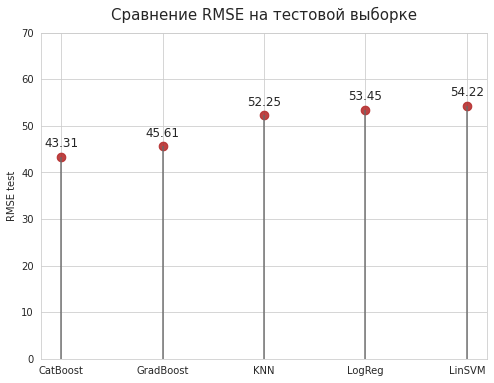

In [262]:
fig, ax = plt.subplots(figsize=(8,6))
ax.vlines(x=sort['model_name'], ymin=0, ymax=sort['rmse_test'], color='dimgrey', alpha=0.7, linewidth=2)
ax.scatter(x=sort['model_name'], y=sort['rmse_test'], s=75, color='firebrick', alpha=0.85)

ax.set_title('Сравнение RMSE на тестовой выборке', size=15, y=(1.02))
ax.set_ylabel('RMSE test')
ax.set_ylim(0, 70)

for row in sort.itertuples():
    ax.text(row.model_name, row.rmse_test+1.5, s=row.rmse_test,
            horizontalalignment= 'center', verticalalignment='bottom', fontsize=12)
  
plt.show()

В ходе анализа было установлено, что только 2 модели смогли продемонстрировать показатель, который удовлетворяет требование по размеру RMSE - это CatBoost и GradientBoostingRegressor. Однако стоить заметить, что данные модели требуют гораздо большего времени обучения, по сравнению с остальными представителями регрессоров в настоящем исследовании.

Переходим к выводам и финальному выводу.


**Вывод**

На данном этапе производилось измерение качества предсказаний на тестовой выборке.
По результатам исследования к применению в реальной работе рекомендуются catboost и gradientboosting. Они продемонстрировали rmse на тестовой выборке 43.72 и 45.65 пунктов соответственно. Время обучения предложенных моделей составляет 4 и 1 секунды, что стоит учитывать при работе с гораздо бОльшими источниками данных.
В рамках текущей задачи rmse = 43 считается допустимой, однако, для более качественного прогноза стоит поискать более полные данные, с большим, вероятно, количеством признаков.



# Общий вывод

Целью настоящего исследования ставилось создание модели, способной предсказать спрос на услуги такси с отклонением до 48 заказов в час.

Результатом тестовых испытаний стали 2 модели, прошедшие установленный порог - catboost и gradietboosting, c показателями 43,31 и 45,61 соответственно.

Также в ходе исследования были протестированы 3 модели - логистическая регрессия, ближайшие соседи и регрессия с опорными векторами, однако ни одна из них не смогла пересечь рубеж в 48 rmse на тестовой выборке.

Отчасти это связано с тем, что в тестовом сепле мы можем наблюдать повышенную дисперсию и общий тренд на увеличение заказов, которые сложно прогноризуются в "начале" сезона. Отчасти именно с этим и связано решение на шаге 4 - обучать модели на максимально полных данных, соединив обучающую и валидационную выборки.

В остальном - данные так же показывают заметную сезонность- пиковые нагрузки приходятся на 00 и 16-17 часов, тогда как минимальное количество заказов поступает ранним утром (6-7 часов) и в 18 часов вечера. На основании этих данных можно создать рекомендацию о дополнительном увеличении количества экипажей такси именно в эти часы.

Цели и задачи исследования достигнуты, однако для улучшения метрики стоит взять больший период времени или найти дополнительные фичи (вопрос к тимлиду и более опытным коллегам).